## <u>SCA6.0 - The CRYPTOCHROME protein family<u/>

**Summary:**  This notebook describes SCA for the Cryptochrome (CRY)/Photolyase family. The CRYs play a critical role in the eukaryotic circadian clock by repressing the transcription factors CLOCK/BMAL1.  CRYs evolved from a family of photoactivated DNA-repair enzymes known as photolyases (PHLs) that catalyze repair of UV-induced DNA lesions. The PHLs have two cofactors, a flavin adenine dinucleotide (FAD) molecule in a central pocket, and a secondary cofactor, which functions as a light-harvesting antenna. By analyzing the pattern of amino acid coevolution across a large and diverse alignment of CRY/PHL sequences, we identified a network of amino acids linking the secondary pocket to the central pocket, suggesting that the secondary pocket is also relevant in the CRYs. Mutational experiments guided by this analysis indicate that the secondary pocket was indeed repurposed in the CRYs to mediate interaction with the transcription factor CLOCK. 
 
 
This analysis accompanies:
Rosensweig C, Reynolds KA, Gao P, Laothamatas I, Shan Y, Ranganathan R, Takahashi JS, Green CB. (2018) "An evolutionary hotspot defines functional differences between CRYPTOCHROMES" Nature Communications v9:1138

<br\>


**Sequence alignment construction:**

1)  PSI-BLAST was run with the full length mCRY1 protein sequence (GenBank Accession ID: AAH85499.1) and the following settings for 2 iterations:
-limit results to 10000
-e-value threshold: 0.01

This resulted in 9995 sequences, which included a large cohort of photolyases.
To remove partial protein fragments, we used the script FilterSeqSize:
    >> ./alnFilterSeqSize2.py Inputs/seq.fa --t 50 120 --output Inputs/FilteredSeqs.fasta
Results:
Average sequence length: 493
Min: 0, Max 2050
Keeping sequences in the range: 443 - 613
Keeping 8069 of 9996 total sequences

2)  The filtered sequences were then aligned with MUSCLE:
    >> ./muscle3.8.31_i86darwin64 -in Inputs/FilteredSeqs.fasta -out Inputs/FilteredSeqsMUSCLE.fasta -maxiters 2
    
3)  And the headers were cleaned up a bit using the following short piece of python code:

import scaTools as sca

headers,seqs = sca.readAlg(‘Inputs/FilteredSeqsMUSCLE.fasta’)
newheaders = list()
for h in headers:
	multi_headers = h.split(‘>’)
	newheaders.append(multi_headers[0])

f = open(‘Inputs/FilteredSeqsMUSCLEHeaderFix.fasta’, ‘w’)
for i,h in enumerate(newheaders):
	f.write(‘>%s\n’ % h)
	f.write(‘%s\n’ % seqs[i])
f.close()


4)  Finally, this alignment was submitted to Promals3D along with the CRY2 structure (4I6E), this yielded the alignment as PromalsComplete.fasta. The headers were replaced using the following script:
    >> ./alnReplaceHeaders.py Inputs/FilteredSeqsMUSCLEHeaderFix.fasta Inputs/FilteredSeqsPromals.fasta --output Inputs/FilteredSeqsPromalsHeaderCorrection.fasta

5) Once the alignment was complete, it was annotated. To do this, the gi numbers were parsed out:
    >> ./alnParseGI.py Inputs/FilteredSeqsPromals.fasta --output Inputs/PromalsCompleteHeaders.gis
And the annotation script was run:
    >> ./annotate_MSA.py Inputs/FilteredSeqsPromalsHeaderCorrection.fasta -o Outputs/CRY20160414_20pct.an -a 'ncbi' -g Inputs/PromalsCompleteHeaders.gis

**Prior to running this tutorial, the core calculation scripts must be executed from the command line as follows:**
    >> ./scaProcessMSA.py Outputs/CRY20160414_20pct.an -s 4I6E -c A -f 'Mus musculus' -p 0.2 0.2 0.2 0.9 -n
    >> ./scaCore.py Outputs/CRY20160414_20pct.db
    >> ./scaSectorID.py Outputs/CRY20160414_20pct.db
    
(all calculations performed using pySCA v.6.3)

**C.Rosensweig, K.Reynolds and R.Ranganathan**
May 2017

In [37]:
%matplotlib inline
from __future__ import division

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile 
import matplotlib.image as mpimg
import colorsys
from random import randint
import scaTools as sca
import cPickle as pickle
from optparse import OptionParser

if not os.path.exists('Outputs/'): os.makedirs('Outputs/')  

#### Load the output of the SCA calculations:

In [38]:
db = pickle.load(open('Outputs/CRY20160414_20pct.db','rb'))
Dseq = db['sequence']  #the results of scaProcessMSA
Dsca = db['sca']       #the results of scaCore
Dsect = db['sector']   #the results of scaSectorID

### I. Alignment composition

In [39]:
print("After processing, the alignment size is %i sequences and %i positions" % (Dseq['Nseq'], Dseq['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq['effseqs']))

After processing, the alignment size is 5385 sequences and 459 positions
With sequence weights, there are 2447 effective sequences


Perform a quick check to make sure that the alignment-to-structure (ats) mapping is good. This is necessary to map alignment positions back to the residue numbering system of a particular PDB file.

In [40]:
ix_ref = [i for i,k in enumerate(Dseq['hd']) if '4I6E' in k]
ix_ref = ix_ref[0]
randcheckpos = [randint(0,len(Dseq['ats'])) for k in range(20)]
for k in randcheckpos:
    print ("Alg Pos: %i, Residue: %s, Struct Pos: %s" % (k,Dseq['alg'][ix_ref][k],Dseq['ats'][k]))

Alg Pos: 255, Residue: R, Struct Pos: -
Alg Pos: 176, Residue: D, Struct Pos: 206
Alg Pos: 400, Residue: P, Struct Pos: 442
Alg Pos: 326, Residue: E, Struct Pos: 368
Alg Pos: 115, Residue: E, Struct Pos: 137
Alg Pos: 167, Residue: S, Struct Pos: 189
Alg Pos: 11, Residue: R, Struct Pos: 32
Alg Pos: 323, Residue: L, Struct Pos: 365
Alg Pos: 439, Residue: I, Struct Pos: 488
Alg Pos: 232, Residue: S, Struct Pos: 270
Alg Pos: 71, Residue: V, Struct Pos: 93
Alg Pos: 228, Residue: P, Struct Pos: 266
Alg Pos: 43, Residue: V, Struct Pos: 65
Alg Pos: 63, Residue: R, Struct Pos: 85
Alg Pos: 391, Residue: P, Struct Pos: 433
Alg Pos: 45, Residue: I, Struct Pos: 67
Alg Pos: 58, Residue: L, Struct Pos: 80
Alg Pos: 441, Residue: N, Struct Pos: 490
Alg Pos: 37, Residue: F, Struct Pos: 59
Alg Pos: 377, Residue: C, Struct Pos: 420


The ats mapping is accurate.

Now, to examine alignment composition, we plot a histogram of all pairwise sequence identities *(left panel)* and a global view of the sequence similarity matrix (defined by $S\equiv \frac{1}{L}XX^\top$) *(right panel)*.  The data show that the alignment is highly structured - there is a roughly trimodal distribution of similarities: a small group of sequences sharing a roughly 45% sequence identity, and two larger groups sharing approximately 25% and 35% sequence identity. The matrix view reveals many small subgroups (or clades) of sequences.  

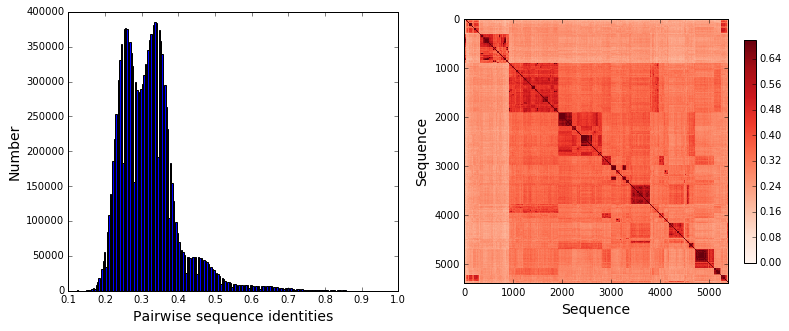

In [41]:
# List all elements above the diagonal (i<j):
listS = [Dsca['simMat'][i,j] for i in range(Dsca['simMat'].shape[0]) \
         for j in range(i+1, Dsca['simMat'].shape[1])]
#Cluster the sequence similarity matrix
Z = sch.linkage(Dsca['simMat'],method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z,no_plot = True)
ind = map(int, R['ivl'])
#Plotting
plt.rcParams['figure.figsize'] = 13, 5
plt.subplot(121)
plt.hist(listS, int(Dseq['Npos']/2))
plt.xlabel('Pairwise sequence identities', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(122)
plt.imshow(Dsca['simMat'][np.ix_(ind,ind)], vmin=0, vmax=0.7, cmap='Reds'); plt.colorbar(shrink=0.8);
plt.xlabel('Sequence', fontsize=14)
plt.ylabel('Sequence', fontsize=14)
#plt.savefig('Figs/SequenceSimilarity.pdf', dpi=300)

In [42]:
print('Seqs in upper left block:  *********************************')
t1_ind = [ind[randint(0,850)] for k in range(20)]
for k in t1_ind:
    sp = Dseq['hd'][k].split('|')
    print sp[4]
print('Seqs in lower right block:  *********************************')
t2_ind = [ind[randint(1000,5000)]for k in range(20)]
for k in t2_ind:
    sp = Dseq['hd'][k].split('|')
    print sp[4]

Seqs in upper left block:  *********************************
 cryptochrome DASH [Phycomyces blakesleeanus]
 MULTISPECIES: deoxyribodipyrimidine photo-lyase [Prochlorococcus]
 cryptochrome 2a [Xenopus laevis] 
 PREDICTED: cryptochrome DASH, chloroplastic/mitochondrial [Beta vulgaris subsp. vulgaris]
 hypothetical protein WALSEDRAFT_53945 [Wallemia mellicola CBS 633.66] 
 cryptochrome [Coniosporium apollinis CBS 100218] 
 hypothetical protein GPECTOR_50g620 [Gonium pectorale]
 PREDICTED: (6-4)DNA photolyase isoform X5 [Elaeis guineensis]
 hypothetical protein [Pedobacter arcticus]
 UVR3 AtUVR3-like 6-4 DNA photolyase protein [Coccomyxa subellipsoidea C-169] 
 6-4 photolyase [Colletotrichum orbiculare MAFF 240422]
 uncharacterized protein Dmoj_GI19664 [Drosophila mojavensis] 
 PREDICTED: (6-4)DNA photolyase-like [Setaria italica] 
 PREDICTED: cryptochrome-2-like isoform X1 [Calidris pugnax]
 PREDICTED: cryptochrome-1-like [Anolis carolinensis]
 predicted protein [Nematostella vectensis] 


**Sequence annotations:** We would like to map co-evolution at particular groups of amino acid positions back to the functional or phylogenetic divergence of particular sequence clades. To enable this, we construct a dictionary of phylogenetic annotations (parsed from the sequence headers) and check the representation of sequences in the top taxonomic levels. For each level, we print a list of taxonomic classes, and the number of sequences found for each. 

In [43]:
#construct a dictionary of phylogenetic groups
annot = dict()
for i, h in enumerate(Dseq['hd']):
    hs = h.split('|')
    if len(hs) < 7:
        annot[hs[1]] = sca.Annot(hs[1], hs[4], hs[5])
    else:
        annot[hs[1]] = sca.Annot(hs[1], hs[5], hs[6])
    
# Most frequent taxonomic groups:
atleast = 10
for level in range(10):
    descr_list = [a.taxo.split(',')[level] for a in annot.values() \
                  if len(a.taxo.split(',')) > level]
    descr_dict = {k:descr_list.count(k) for k in descr_list \
                  if descr_list.count(k)>=atleast}
    print '\n Level %i:' % level
    print descr_dict    


 Level 0:
{'cellular organisms': 5375}

 Level 1:
{' Archaea': 164, ' Eukaryota': 1059, ' Bacteria': 4152}

 Level 2:
{' Alveolata': 13, ' Stramenopiles': 39, ' Viridiplantae': 306, ' TACK group': 18, ' Terrabacteria group': 1349, ' FCB group': 374, ' Nitrospirae': 15, ' Euryarchaeota': 139, ' PVC group': 35, ' Opisthokonta': 689, ' Proteobacteria': 2347, ' unclassified Bacteria': 16}

 Level 3:
{' Gammaproteobacteria': 1203, ' Betaproteobacteria': 488, ' Chlamydiae': 13, ' Nitrospira': 15, ' Halobacteria': 128, ' Chlorophyta': 20, ' Firmicutes': 244, ' Verrucomicrobia': 14, ' Methanomicrobia': 11, ' Cyanobacteria/Melainabacteria group': 289, ' Fungi': 240, ' Actinobacteria': 782, ' Bacteroidetes/Chlorobi group': 373, ' Oomycetes': 25, ' Chloroflexi': 27, ' Alphaproteobacteria': 630, ' delta/epsilon subdivisions': 22, ' Streptophyta': 286, ' Metazoa': 444}

 Level 4:
{' Bacilli': 242, ' Neisseriales': 41, ' Peronosporales': 19, ' Nitrospirales': 15, ' unclassified Alphaproteobacteria'

Based on this, we select taxonomic groups and associate them to colors for representation.  We choose broad taxonomic groups that are well-represented in the alignment. To see a complete legend that maps numeric codes to color, use: 
    
    >>> sca.figColors()

In [44]:
phylo = list();
fam_names = ['Bacteria', 'Archaea', 'Vertebrata','Viridiplantae','Neoptera']
col = (1, 0.75, 0.5, 0.4, 0.92) 
#Bacteria = gray, Archaea = purple, Vertebrata = cyan, 
#Viridiplantae = green, Neoptera = pink
for i,k in enumerate(fam_names):
    sf = sca.Unit()
    sf.name = fam_names[i].lower()
    sf.col = col[i]
    sf.items = [j for j,q in enumerate(Dseq['hd'])  if sf.name in q.lower()]
    phylo.append(sf)

We also attempt to annotate the sequences by their declared classification as a PHL or CRY.  These annotations are simply parsed from the header, and could contain mis-assignments.

In [45]:
cry_names = ['photo', 'cry']
cry_classes = list()
col = (1, 0.7)
#Cryptochrome=blue, Photolyase=gray
for c,k in enumerate(cry_names):
    gp = sca.Unit()
    gp.col = col[c]
    gp.name = k
    gp.items = [i for i,h in enumerate(Dseq['hd']) if k in h]
    cry_classes.append(gp)

In [46]:
#a more refined annotation set: 
cry_names2 = ['photo', 'cryptochrome-1', 'cryptochrome-2']
cry_classes2 = list()
col = (1, 0.7, 0.05)
#Cryptochrome1 =blue, cryptochrome2 = red, Photolyase=gray
for c,k in enumerate(cry_names2):
    gp = sca.Unit()
    gp.col = col[c]
    gp.name = k
    gp.items = [i for i,h in enumerate(Dseq['hd']) if k in h]
    cry_classes2.append(gp)

### II. <u> First-order statistics: position-specific conservation.<u/>

We would like to compare the conservation values for the sequence as a whole with positions in the FAD binding and secondary pockets.  We selected positions within a 4A radius of the FAD and secondary pockets (both of which were defined relative to the *A. Nidulans* photolyase structure, 1TEZ.pdb). We start by figuring out the indices for these structural positions in our alignment. 

In [47]:
PHL_secpock = ['10','35','36','37','38','41','42','47','51','55','101','103',\
               '106','109','248','249']
PHL_FADpock = ['228','240','241','242','243','244','247','280','283','284',\
               '287','290','346','347','349','352','353','356','374','378',\
               '380','381','382','385','386','389','390']

#first have to make a mapping between the positions in mouse CRY2 (4I6E or 4I6G.pdb)
#and the A.Nidulans photolyase
PHLiref = '6401'
CRY2iref = '565'
aln = 'Outputs/CRY20160414_20pct.an'

cmd1 = './scaMakeATS.py '+aln+' -i '+PHLiref+ ' -o Inputs/PHL.pos --output Outputs/ATS_PHL > Outputs/ATS_PHL.log'
print cmd1; 
os.system(cmd1)
dbtmp= pickle.load(open('Outputs/ATS_PHL.db', 'rb'))
ATSmapPHL = (dbtmp['sequence']['ats'])

cmd1 = './scaMakeATS.py '+aln+' -i '+CRY2iref+ ' -o Inputs/CRY2.pos --output Outputs/ATS_CRY2 > Outputs/ATS_CRY2.log'
print cmd1; 
os.system(cmd1)
dbtmp= pickle.load(open('Outputs/ATS_CRY2.db', 'rb'))
ATSmapCRY2 = (dbtmp['sequence']['ats'])

#define the analogous secondary pocket and FAD pocket positions in CRY2 - this also serves as a check of the mapping
PHL_secpockix = [ATSmapPHL.index(k) for k in PHL_secpock]
CRY2_secpock = [ATSmapCRY2[k] for k in PHL_secpockix]
PHL_FADpockix = [ATSmapPHL.index(k) for k in PHL_FADpock]
CRY2_FADpock = [ATSmapCRY2[k] for k in PHL_FADpockix]
print 'CRY2 secondary pocket: '
print '+'.join(CRY2_secpock)
print 'CRY2 FAD pocket: '
print '+'.join(CRY2_FADpock)

SecPockIx = [Dseq['ats'].index(k) for k in CRY2_secpock if k in Dseq['ats']]
FADPockIx = [Dseq['ats'].index(k) for k in CRY2_FADpock if k in Dseq['ats']]

./scaMakeATS.py Outputs/CRY20160414_20pct.an -i 6401 -o Inputs/PHL.pos --output Outputs/ATS_PHL > Outputs/ATS_PHL.log
./scaMakeATS.py Outputs/CRY20160414_20pct.an -i 565 -o Inputs/CRY2.pos --output Outputs/ATS_CRY2 > Outputs/ATS_CRY2.log
CRY2 secondary pocket: 
28+53+54+55+56+59+60+65+69+73+119+121+124+127+274+275
CRY2 FAD pocket: 
252+266+267+268+269+270+273+304+307+308+311+314+370+371+373+376+377+380+399+403+405+406+407+410+411+414+415


Plot the position-specific conservation values for each CRY position. $D_i$ corresponds to the Kullback-Leibler relative entropy; larger values are more conserved. The subset of moderate-to-highly conserved positions ($D_i$ > 1.5) is largely contained in the protein core, and  around the primary (FAD) binding site. FAD binding pocket residues are colored blue, secondary pocket residues are colored red.

Conserved Positions - 128 total (0.278867 of sequence)
26+27+28+30+31+32+35+36+39+42+53+54+56+72+77+80+84+91+96+114+117+128+164+166+167+168+170+231+232+242+266+267+269+270+272+273+276+278+279+281+304+307+308+310+311+312+313+314+322+338+348+351+353+354+355+356+358+359+360+362+363+364+365+368+369+370+371+372+373+374+376+377+379+380+381+382+383+384+385+388+390+391+392+395+398+399+403+405+407+409+411+414+415+416+417+419+420+421+422+424+426+427+428+429+430+431+432+433+436+439+440+441+444+446+447+448+450+452+453+454+463+465+484+485+487+488+489+491


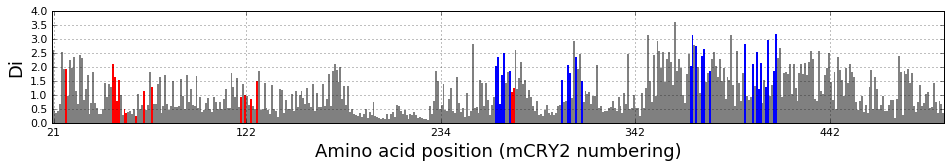

In [48]:
consPos = [Dseq['ats'][i] for i,k in enumerate(Dsca['Di']) if (k > 1.5) & (Dseq['ats'][i] != '-')]
print ('Conserved Positions - %i total (%f of sequence)' % (len(consPos),len(consPos)/len(Dseq['ats'])))
print '+'.join(consPos)

fig, axs = plt.subplots(1,1, figsize=(16,2))
Di_p1, Di_p2, Di_nonsect = [],[],[]
pos_p1, pos_p2, pos_nonsect = [],[],[]
for i,k in enumerate(Dseq['ats']):
    if k in CRY2_FADpock:
        Di_p1.append(Dsca['Di'][i])
        pos_p1.append(i)
    elif k in CRY2_secpock:
        Di_p2.append(Dsca['Di'][i])
        pos_p2.append(i)
    else:
        Di_nonsect.append(Dsca['Di'][i])
        pos_nonsect.append(i)

plt.bar(pos_nonsect,Di_nonsect, color=[0.5, 0.5, 0.5], width = 1, linewidth = 0)
plt.bar(pos_p1,Di_p1,color =[0,0,1], width = 1, linewidth = 0)
plt.bar(pos_p2,Di_p2,color =[1,0,0], width = 1, linewidth = 0)

plt.xlim(0,len(Dseq['ats'])); plt.ylim(0,4)
xticks = [1,100,200,300,400]
axs.set_xticks(xticks);
plt.tick_params(labelsize=11); plt.grid()
labels = [Dseq['ats'][k] for k in xticks]
axs.set_xticklabels(labels);
plt.xlabel('Amino acid position (mCRY2 numbering)', fontsize=18); plt.ylabel('Di', fontsize=18);

#plt.savefig('Figs/DiGraph.pdf', dpi=300)

Now examine the distribution of conservation values for positions in an 4A radius around the secondary pocket and FAD pocket. (This plot is Fig. 1c of the manuscript, but with diff colorcoding - blue indicates the fad binding pocket, and red the secondary binding pocket)

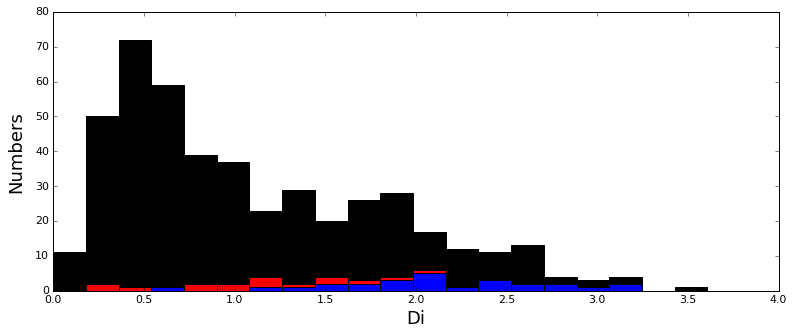

In [49]:
#examine the distribution of sequence conservation in these residue groups 
#(as compared to the remainder of the sequence)
otherres = [k for k in range(len(Dsca['Di'])) if (k not in SecPockIx) & (k not in FADPockIx) ]

Diotherres = [Dsca['Di'][k] for k in otherres]
histallres, bins = np.histogram(Diotherres, bins=20,range=(0,Dsca['Di'].max()))
secposDi = [Dsca['Di'][k] for k in SecPockIx]
fadposDi = [Dsca['Di'][k] for k in FADPockIx]
histsecpos, bins = np.histogram(secposDi, bins=20,range=(0,Dsca['Di'].max()))
histfadpos, bins = np.histogram(fadposDi, bins=20,range=(0,Dsca['Di'].max()))

plt.bar(bins[:-1], histfadpos, np.diff(bins),color='b')
plt.bar(bins[:-1], histsecpos, np.diff(bins),bottom=histfadpos,color='r')
bot = [histfadpos[k] + histsecpos[k] for k in range(len(histfadpos))]
plt.bar(bins[:-1], histallres, np.diff(bins),bottom=bot,color='k')

plt.tick_params(labelsize=11)
plt.xlabel('Di', fontsize=18, labelpad=5); plt.ylabel('Numbers', fontsize=18, labelpad=10);
#plt.savefig('PocketConservation.pdf', dpi=300)

Write to file the alignment for the FAD and secondary pocket positions - these are the input for producing a seqlogo plot (as in Fig 1E-F). 

In [50]:
for fam in cry_classes:
    f1 = open('Outputs/'+fam.name+'_FADPock.fasta','w')
    f2 = open('Outputs/'+fam.name+'_SecPock.fasta','w')
    randSelSeqs = [fam.items[randint(0,len(fam.items)-1)] for k in range(1000)]
    for k in randSelSeqs:
        FADPockTmp = [Dseq['alg'][k][j] for j in FADPockIx]
        if '-' not in FADPockTmp:
            f1.write('>'+ Dseq['hd'][k]+'\n')
            f1.write(''.join(FADPockTmp)+'\n')
        SecPockTmp = [Dseq['alg'][k][j] for j in SecPockIx]
        if '-' not in SecPockTmp:
            f2.write('>'+ Dseq['hd'][k]+'\n')
            f2.write(''.join(SecPockTmp)+'\n')
    f1.close()
    f2.close()

We also have a look at the level of conservation for the point mutations described in this work.

In [51]:
#figure out the indexing for the point mutants:
mutPosCRY1 = [38,39,41,51,103,105,106,109,257,382]
ctrlmutPosCRY1 = [107,108]
mutPosCRY2 = [str(k+18) for k in mutPosCRY1]
ctrlmutPosCRY2 = [str(k+18) for k in ctrlmutPosCRY1]
mutPosCRY2ix = [Dseq['ats'].index(str(k)) for k in mutPosCRY2]
ctrlmutPosCRY2ix = [Dseq['ats'].index(str(k)) for k in ctrlmutPosCRY2]

In [52]:
print('Conservation for secondary pocket mutations (in sector):')
for k in mutPosCRY2ix:
    print (Dseq['alg'][ix_ref][k]+str(k)+': '+str(Dsca['Di'][k]))
print('Conservation for secondary pocket mutations (NOT in sector):')
for k in ctrlmutPosCRY2ix:
    print (Dseq['alg'][ix_ref][k]+str(k)+': '+str(Dsca['Di'][k]))

Conservation for secondary pocket mutations (in sector):
D34: 1.52710616738
P35: 0.991974170656
F37: 0.494077237332
R47: 1.13910897739
E99: 0.97900623861
F101: 0.651846582228
G102: 0.839888298473
R105: 1.48816548645
F237: 1.24975385073
D357: 0.955294160136
Conservation for secondary pocket mutations (NOT in sector):
K103: 0.610150705019
E104: 0.483660310107


### III. <u>Second-order statistics: conserved correlations.<u/>

Plot the full SCA correlation matrix ( $\tilde{C_{ij}}$ ). This describes the conservation-weighted covariation between all pairs of positions in the CRY/PHL family. As for most other SCA matrices studied to date, we see that the pattern of co-evolution is sparse (most pixels are blue/most positions don't co-evolve), and distributed (co-evolution isn't localized in the primary sequence) 

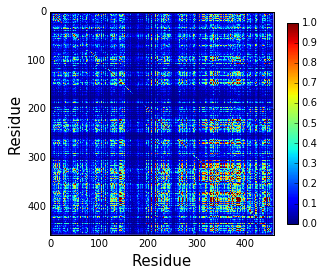

In [53]:
plt.rcParams['figure.figsize'] = 5, 4.5
plt.imshow(Dsca['Csca'], vmin=0, vmax=1,interpolation='none',\
           aspect='equal'); plt.colorbar(shrink=0.8);
plt.xlabel('Residue', fontsize=15)
plt.ylabel('Residue', fontsize=15)
#plt.savefig('SCAcorrelationMat.png', dpi=300)

To analyze the matrix, we conduct principal components analysis and compare the distribution of eigenvalues to those obtained from a random matrix model. Here we plot the eigenspectrum of (1) the SCA positional coevolution matrix ($\tilde{C_{ij}}$) *(black bars)* and (2) 10 trials of matrix randomization for comparison (as in Fig. 3C of the main text). This graph is used to choose the number of significant eigenmodes ($k^* = 21$).

Number of eigenmodes to keep is 21


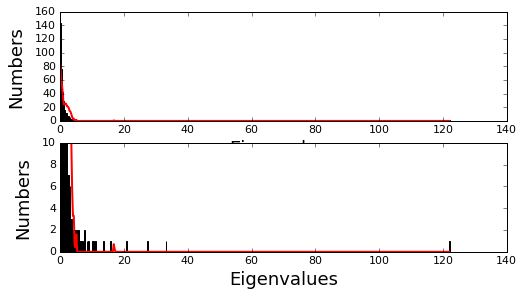

In [54]:
plt.rcParams['figure.figsize'] = 8, 4.3
hist0, bins = np.histogram(Dsca['Lrand'].flatten(), bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
hist1, bins = np.histogram(Dsect['Lsca'], bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
plt.subplot(211)
plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=2)
plt.tick_params(labelsize=11)
plt.xlabel('Eigenvalues', fontsize=18, labelpad=5); plt.ylabel('Numbers', fontsize=18, labelpad=10);

plt.subplot(212)
plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=2)
plt.tick_params(labelsize=11)
plt.ylim([0,10])
plt.xlabel('Eigenvalues', fontsize=18, labelpad=5); plt.ylabel('Numbers', fontsize=18, labelpad=10);
#plt.savefig('Eigenspectrum.png', dpi=300)
print 'Number of eigenmodes to keep is %i' %(Dsect['kpos'])

The large number of significant ICs suggests a rich decomposition of the CRY/PHL family sequence into little groups of co-evolving residues. This likely reflects the fact that this alignment contains a good deal structured sequence clades or subfamilies.  To investigate the top modes more carefully, we plot the top most significant eigenmodes *(top row)* and associated independent components *(bottom row)*. In these plots, each point represents a particular amino acid position, and positions which are proximal are more highly co-evolving. 

We construct an inclusive sector definition which includes all positions with a contribution to the top eigenmode (EV0 > 0.03). These positions are colored blue. 

To visualize the relationship between the pattern of amino acid co-evolution and structure, we also color-code the positions by location. Positions in the secondary pocket are colored yellow, and in the FAD pocket are colored magenta. (Corresponds to Fig. 2A).

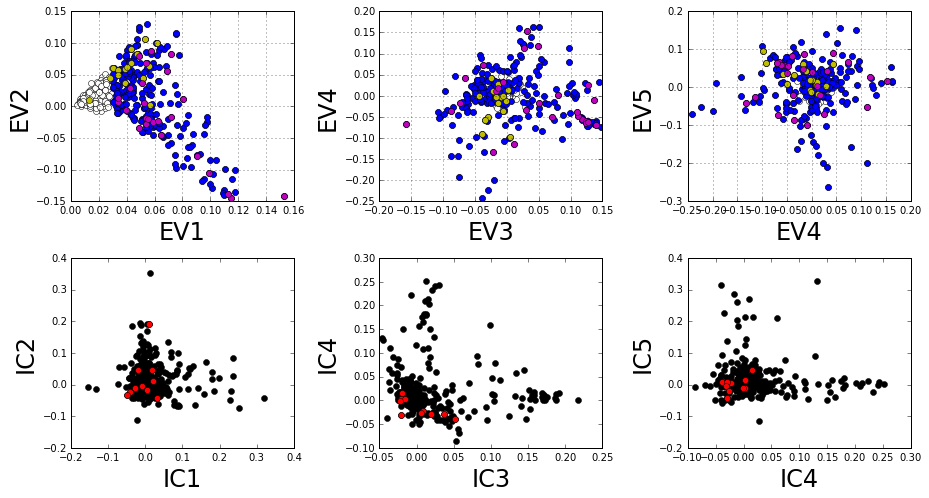

In [55]:
plt.rcParams['figure.figsize'] = 13, 7
pairs = [[0,1],[2,3],[3,4]]
EVs = Dsect['Vsca']
ICs = Dsect['Vpica']

EVsecdef = [i for i,k in enumerate(EVs[:,0]) if ((k > 0.030))]
ats_EVsecdef = [Dseq['ats'][s] for s in EVsecdef if (Dseq['ats'][s] != '-')]

for k,[k1,k2] in enumerate(pairs):
    plt.subplot(2,3,k+1)
    plt.plot(EVs[:,k1], EVs[:,k2], 'ow')
    for j,m in enumerate(EVsecdef):
        plt.plot(EVs[m,k1], EVs[m,k2], 'ob')
    for j,m in enumerate(SecPockIx):
        plt.plot(EVs[m,k1], EVs[m,k2], 'oy')
    for j,m in enumerate(FADPockIx):
        plt.plot(EVs[m,k1], EVs[m,k2], 'om')

    plt.xlabel("EV%i"%(k1+1), fontsize=24)
    plt.ylabel("EV%i"%(k2+1), fontsize=24)
    plt.grid()
    plt.subplot(2,3,k+4)
    plt.plot(ICs[:,k1], ICs[:,k2], 'ok')
    for j,m in enumerate(mutPosCRY2ix):
        plt.plot(ICs[m,k1], ICs[m,k2], 'or')
    plt.xlabel("IC%i"%(k1+1), fontsize=24)
    plt.ylabel("IC%i"%(k2+1), fontsize=24)
plt.tight_layout()
#plt.savefig('Figs/EVIC_2.pdf', dpi=300)

In [56]:
print ('Sector definition (%i pos, %f of the protein): '%(len(EVsecdef), len(EVsecdef)/len(Dseq['ats'])))
print ','.join(ats_EVsecdef)

#define a sector object that will be useful for later plots
EVsector = []
s = sca.Unit()    
s.items = EVsecdef
s.col = 0.6
EVsector.append(s)

Sector definition (260 pos, 0.566449 of the protein): 
26,27,28,29,30,31,32,34,35,36,37,38,39,42,49,51,53,54,55,56,57,59,66,68,69,71,72,73,74,76,77,79,80,84,89,91,93,96,98,111,114,115,116,117,118,119,120,121,122,123,124,127,128,131,135,140,145,147,148,149,150,151,152,153,154,156,158,161,163,164,165,166,167,168,169,170,171,172,174,187,220,228,230,231,232,235,238,239,242,258,259,260,261,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,304,305,306,307,308,309,310,311,312,313,314,316,317,318,320,321,322,329,330,333,334,336,338,345,347,348,349,351,353,354,355,356,357,358,359,360,361,362,363,364,365,366,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,387,388,389,390,391,392,393,395,396,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,435,436,437,438,439,440,441,442,444,446,447,448,450,451,452,453,454,457,458,462,463,465,466,473,484,485,487,488,

### IV. Sequence subfamilies and the basis of the sector hierarchy.

How does the phylogenetic and functional heterogeneity in the MSA influence the sector d?  To address this, we take advantage of mathematical methods for mapping between the space of positional and sequence correlations, as described in *Rivoire et al* (2016) PLoS Comp Biol 2(6): e1004817.  Using this mapping, we plot the eigenvectors of the matrix $\tilde{C_{ij}}$ as 2-D scatter plots *(top row)*, and compare them to the corresponding sequence space divergence *(middle and bottom rows)*.   The sequences are color-coded according to phylogenetic classifications *(middle row)* or CRY/PHL class *(bottom row)* as we defined above. 

In this case, we do not see strong seperation by phylogenetic group or by CRY/PHL class, suggesting that the sector is a conserved, family-wide feature (corresponds to manuscript Fig. 2BC)

In [57]:
ix_ref_PHL1 = [i for i,k in enumerate(Dseq['hd']) if '1TEZ' in k]
ix_ref_PHL1 = ix_ref_PHL1[0]

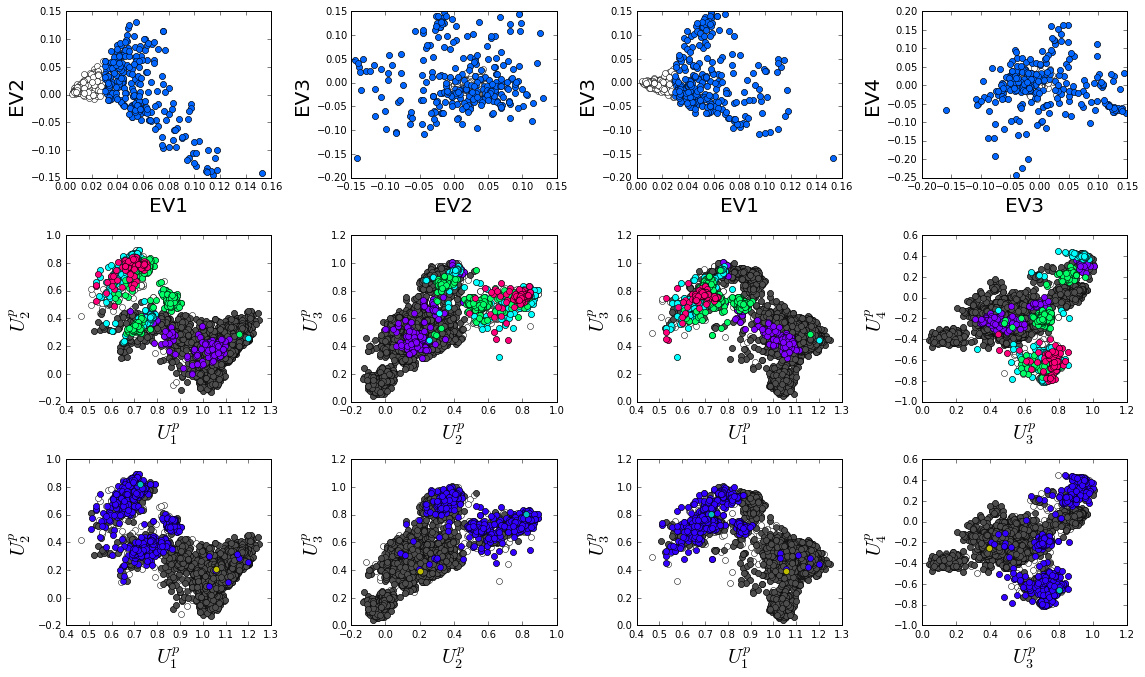

In [58]:
#looking at projection from Eigenvectors to sequences.
plt.rcParams['figure.figsize'] = 16, 12 
pairs= [[0,1],[1,2],[0,2],[2,3]]

for n,[k1,k2] in enumerate(pairs):
    plt.subplot(4,4,n+1)
    sca.figUnits(Dsect['Vsca'][:,k1], Dsect['Vsca'][:,k2], \
                 EVsector, dotsize = 6)
    plt.xlabel('EV%i' % (k1+1), fontsize=20)
    plt.ylabel('EV%i' % (k2+1), fontsize=20)
    
    plt.subplot(4,4,n+5)
    sca.figUnits(Dsect['Usca'][:,k1], Dsect['Usca'][:,k2], \
                 phylo, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=20)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=20)
    
    plt.subplot(4,4,n+9)
    sca.figUnits(Dsect['Usca'][:,k1], Dsect['Usca'][:,k2], \
                 cry_classes, dotsize = 6)
    plt.plot(Dsect['Usca'][ix_ref,k1], Dsect['Usca'][ix_ref,k2], 'oc') #mouse cry2
    plt.plot(Dsect['Usca'][ix_ref_PHL1,k1], Dsect['Usca'][ix_ref_PHL1,k2], 'oy') #cyano PHL
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=20)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=20)

plt.tight_layout()
#plt.savefig('Figs/Subfamilies4x4.png', dpi=300)

In [59]:
print('Seqs in upper left island, U1/U2:  *********************************')
testseqs = [k for k in range(len(Dseq['hd'])) if ((Dsect['Usca'][k,0] > 0.8) and (Dsect['Usca'][k,1] > 0.4))]
t1_ind = [testseqs[randint(0,len(testseqs))] for k in range(20)]
for k in t1_ind:
    print '----------------'
    sp = Dseq['hd'][k].split('|')
    print sp[6]

Seqs in upper left island, U1/U2:  *********************************
----------------
cellular organisms, Bacteria, Terrabacteria group, Cyanobacteria/Melainabacteria group, Cyanobacteria, Pleurocapsales, Myxosarcina
----------------
cellular organisms, Bacteria, Proteobacteria, Alphaproteobacteria, Rhodospirillales, Rhodospirillaceae, Azospirillum
----------------
cellular organisms, Bacteria, Proteobacteria, Alphaproteobacteria, Caulobacterales, Caulobacteraceae, unclassified Caulobacteraceae
----------------
cellular organisms, Eukaryota, Viridiplantae, Streptophyta, Streptophytina, Embryophyta, Tracheophyta, Euphyllophyta, Spermatophyta, Magnoliophyta, Mesangiospermae, eudicotyledons, Gunneridae, Pentapetalae, rosids, malvids, Malvales, Malvaceae, Malvoideae, Gossypium
----------------
cellular organisms, Eukaryota, Viridiplantae, Streptophyta, Streptophytina, Embryophyta, Tracheophyta, Euphyllophyta, Spermatophyta, Magnoliophyta, Mesangiospermae, eudicotyledons, Gunneridae, Pentap